Now we train. Since this takes time (approx. 10-20 mins per epoch depending on the GPU), we need to add Callbacks. These are "safety nets" that monitor the training.

**ModelCheckpoint**: Saves the model only when it improves (so you don't lose the best version if the training gets worse later).

**EarlyStopping**: Stops training automatically if the model stops learning (saves you time).

**ReduceLROnPlateau**: If the model gets stuck, this lowers the "learning rate" to help it fine-tune better.

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# --- PART A: Setup Visualization Directory & Sample ---

# 1. Create a directory to save the images
VIS_DIR = '/content/project/epoch_visualizations'
if not os.path.exists(VIS_DIR):
    os.makedirs(VIS_DIR)
    print(f"📂 Created visualization directory: {VIS_DIR}")

# 2. Pick ONE fixed validation image to track
# We pick a random index once, so we track the SAME image every epoch
sample_idx = random.randint(0, len(val_image_paths)-1)
raw_sample_img_path = val_image_paths[sample_idx]
raw_sample_mask_path = val_mask_paths[sample_idx]

print(f"👁️ Selected sample image index: {sample_idx}")

# 3. Preprocess the sample (Same logic as our data pipeline)
IMG_HEIGHT = 256
IMG_WIDTH = 256

# Process Image
sample_img_processed = tf.io.read_file(raw_sample_img_path)
sample_img_processed = tf.io.decode_png(sample_img_processed, channels=3)
sample_img_processed = tf.image.resize(sample_img_processed, [IMG_HEIGHT, IMG_WIDTH])
sample_img_processed = sample_img_processed / 255.0
sample_img_for_model = tf.expand_dims(sample_img_processed, axis=0) # Add batch dimension

# Process Mask (for comparison)
sample_mask_processed = tf.io.read_file(raw_sample_mask_path)
sample_mask_processed = tf.io.decode_png(sample_mask_processed, channels=1)
sample_mask_processed = tf.image.resize(sample_mask_processed, [IMG_HEIGHT, IMG_WIDTH], method='nearest')
sample_mask_true = sample_mask_processed.numpy()

# --- PART B: Define the Custom Callback Class ---

class EpochVisualizer(Callback):
    def __init__(self, model, sample_img_input, sample_mask_true, save_dir):
        self.working_model = model
        self.sample_img = sample_img_input
        self.true_mask = sample_mask_true
        self.save_dir = save_dir

    def on_epoch_end(self, epoch, logs=None):
        # 1. Predict
        pred_probs = self.working_model.predict(self.sample_img, verbose=0)
        pred_mask = np.argmax(pred_probs[0], axis=-1)

        # 2. Plot
        plt.figure(figsize=(15, 5))

        # Original Image
        plt.subplot(1, 3, 1); plt.title("Input Image"); plt.axis('off')
        plt.imshow((self.sample_img[0].numpy() * 255).astype(np.uint8))

        # True Mask
        plt.subplot(1, 3, 2); plt.title("True Mask"); plt.axis('off')
        plt.imshow(self.true_mask[:,:,0] * 5, cmap='gray') # *5 for contrast

        # Prediction
        plt.subplot(1, 3, 3); plt.title(f"Prediction (Epoch {epoch+1})"); plt.axis('off')
        plt.imshow(pred_mask * 5, cmap='gray') # *5 for contrast

        # 3. Save
        filename = os.path.join(self.save_dir, f"epoch_{epoch+1:02d}.png")
        plt.savefig(filename)
        plt.close()
        # print(f"Saved visualization to {filename}")

# --- PART C: Define Callbacks & Train ---

# Define where to save the best model weights
checkpoint_path = '/content/project/best_unet_model.keras'

# Initialize our visualizer
visualizer_callback = EpochVisualizer(model, sample_img_for_model, sample_mask_true, VIS_DIR)

callbacks = [
    # Save the model only when it improves
    ModelCheckpoint(checkpoint_path, verbose=1, save_best_only=True, monitor='val_loss'),
    # Stop if no improvement for 5 epochs (patience)
    EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True), # Reduce patience to exit if too much time taken for improvement. Stop if no improvement for 3 epochs.
    # Reduce learning rate if stuck
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001, verbose=1),
    # OUR CUSTOM VISUALIZER
    visualizer_callback
]

print("🚀 Starting Training... Check '/content/project/epoch_visualizations' in your Drive!")

history = model.fit(
    train_dataset,
    epochs=20, # Reduce Number of Epoch to get faster training. 25 better quality.
    validation_data=val_dataset,
    callbacks=callbacks
)

print("✅ Training Finished!")

👁️ Selected sample image index: 1
🚀 Starting Training... Check '/content/project/epoch_visualizations' in your Drive!
Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - accuracy: 0.7170 - loss: 0.9942
Epoch 1: val_loss improved from inf to 0.95131, saving model to /content/project/best_unet_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.7175 - loss: 0.9921 - val_accuracy: 0.7132 - val_loss: 0.9513 - learning_rate: 0.0010
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - accuracy: 0.7268 - loss: 0.9328
Epoch 2: val_loss improved from 0.95131 to 0.88228, saving model to /content/project/best_unet_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7270 - loss: 0.9329 - val_accuracy: 0.7390 - val_loss: 0.8823 - learning_rate: 0.0010
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 749ms/step - accuracy: 0.7572 - loss: 0.8547
Epoch 3: val_loss did not improve from 0.88228
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7571 - loss: 0.8547 - val_accuracy: 0.7454 - val_loss: 0.8946 - learning_rate: 0.0010
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 748ms/step - accuracy: 0.7542 - loss: 0.8532
Epoch 4: val_loss improved from 0.88228 to 0.82343, saving model to /content/project/best_unet_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7544 - loss: 0.8525 - val_accuracy: 0.7611 - val_loss: 0.8234 - learning_rate: 0.0010
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 742ms/step - accuracy: 0.7714 - loss: 0.8103
Epoch 5: val_loss did not improve from 0.82343
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7717 - loss: 0.8091 - val_accuracy: 0.7620 - val_loss: 0.8259 - learning_rate: 0.0010
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - accuracy: 0.7842 - loss: 0.7590
Epoch 6: val_loss improved from 0.82343 to 0.82183, saving model to /content/project/best_unet_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7841 - loss: 0.7595 - val_accuracy: 0.7638 - val_loss: 0.8218 - learning_rate: 0.0010
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - accuracy: 0.7784 - loss: 0.7709
Epoch 7: val_loss improved from 0.82183 to 0.70454, saving model to /content/project/best_unet_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7787 - loss: 0.7704 - val_accuracy: 0.8050 - val_loss: 0.7045 - learning_rate: 0.0010
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - accuracy: 0.7998 - loss: 0.7308
Epoch 8: val_loss did not improve from 0.70454
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7997 - loss: 0.7301 - val_accuracy: 0.8033 - val_loss: 0.7068 - learning_rate: 0.0010
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - accuracy: 0.7938 - loss: 0.7294
Epoch 9: val_loss improved from 0.70454 to 0.68059, saving model to /content/project/best_unet_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7941 - loss: 0.7286 - val_accuracy: 0.8100 - val_loss: 0.6806 - learning_rate: 0.0010
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - accuracy: 0.8148 - loss: 0.6685
Epoch 10: val_loss improved from 0.68059 to 0.66136, saving model to /content/project/best_unet_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8144 - loss: 0.6695 - val_accuracy: 0.8152 - val_loss: 0.6614 - learning_rate: 0.0010
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 746ms/step - accuracy: 0.8077 - loss: 0.6973
Epoch 11: val_loss did not improve from 0.66136
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8074 - loss: 0.6979 - val_accuracy: 0.8149 - val_loss: 0.6639 - learning_rate: 0.0010
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step - accuracy: 0.8080 - loss: 0.6804
Epoch 12: val_loss improved from 0.66136 to 0.62014, saving model to /content/project/best_unet_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8082 - loss: 0.6801 - val_accuracy: 0.8280 - val_loss: 0.6201 - learning_rate: 0.0010
Epoch 13/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - accuracy: 0.8304 - loss: 0.6231
Epoch 13: val_loss improved from 0.62014 to 0.59347, saving model to /content/project/best_unet_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8303 - loss: 0.6231 - val_accuracy: 0.8361 - val_loss: 0.5935 - learning_rate: 0.0010
Epoch 14/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0.8280 - loss: 0.6281
Epoch 14: val_loss improved from 0.59347 to 0.59006, saving model to /content/project/best_unet_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8283 - loss: 0.6269 - val_accuracy: 0.8361 - val_loss: 0.5901 - learning_rate: 0.0010
Epoch 15/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - accuracy: 0.8349 - loss: 0.5977
Epoch 15: val_loss improved from 0.59006 to 0.57152, saving model to /content/project/best_unet_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8350 - loss: 0.5974 - val_accuracy: 0.8433 - val_loss: 0.5715 - learning_rate: 0.0010
Epoch 16/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - accuracy: 0.8323 - loss: 0.6046
Epoch 16: val_loss did not improve from 0.57152
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8326 - loss: 0.6034 - val_accuracy: 0.8389 - val_loss: 0.5879 - learning_rate: 0.0010
Epoch 17/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - accuracy: 0.8294 - loss: 0.6174
Epoch 17: val_loss did not improve from 0.57152

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8293 - loss: 0.6173 - val_accuracy: 0.8341 - val_loss: 0.5891 - learning_rate: 0.0010
Epoch 18/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - accuracy: 0.8371 - loss: 0.5900
Epoch 18: val_loss improved from 0.57152 to 0.54364, saving model to /content/project/best_unet_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8374 - loss: 0.5889 - val_accuracy: 0.8492 - val_loss: 0.5436 - learning_rate: 5.0000e-04
Epoch 19/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 740ms/step - accuracy: 0.8534 - loss: 0.5306
Epoch 19: val_loss improved from 0.54364 to 0.52686, saving model to /content/project/best_unet_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.8533 - loss: 0.5308 - val_accuracy: 0.8550 - val_loss: 0.5269 - learning_rate: 5.0000e-04
Epoch 20/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - accuracy: 0.8510 - loss: 0.5324
Epoch 20: val_loss improved from 0.52686 to 0.51153, saving model to /content/project/best_unet_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8512 - loss: 0.5318 - val_accuracy: 0.8581 - val_loss: 0.5115 - learning_rate: 5.0000e-04
✅ Training Finished!


Once the training finishes (or stops early), you need to see if it actually worked. We do this by plotting the Loss (Error) and Accuracy.

**Loss** (Left Graph): Should go DOWN. If it goes up, something is wrong.

**Accuracy** (Right Graph): Should go UP.

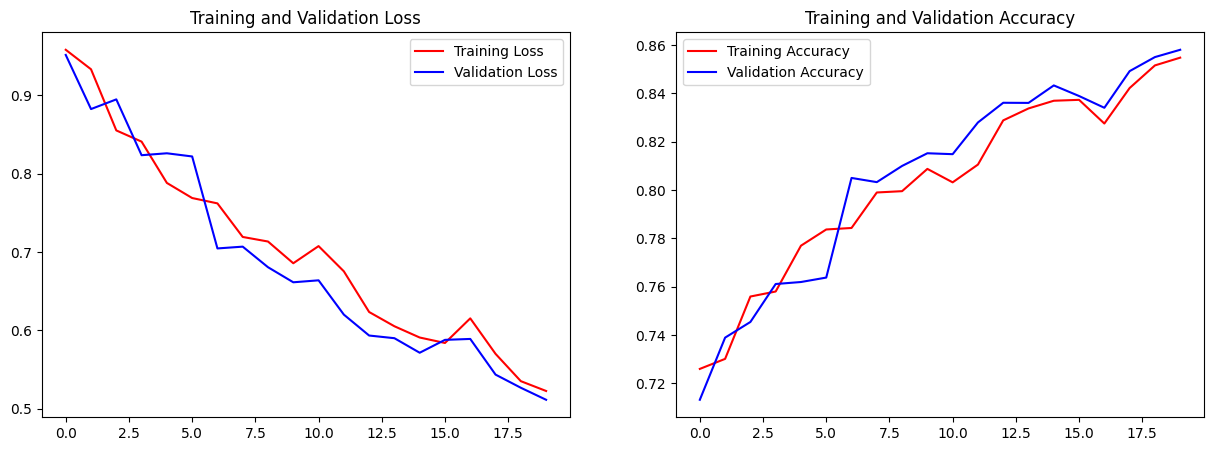

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(len(loss))

    plt.figure(figsize=(15, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

plot_history(history)